<a href="https://colab.research.google.com/github/yashlal/Deepfake-Microbiomes/blob/main/ArchitectureGPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CUDA device selected!
Using 1 GPU



Epoch 0: Loss 0.5793979041935454
Epoch 1: Loss 0.578810599057318
Epoch 2: Loss 0.578233989310203
Epoch 3: Loss 0.577641309665726
Epoch 4: Loss 0.5769895362174707
Epoch 5: Loss 0.5764989181836269
Epoch 6: Loss 0.575793997408054
Epoch 7: Loss 0.5752959837447728
Epoch 8: Loss 0.5746709129304318
Epoch 9: Loss 0.5741188973845379



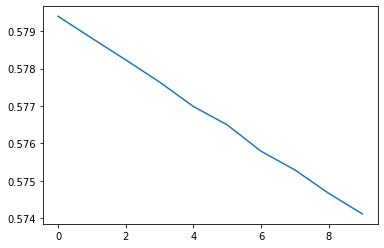

In [5]:
from newsolver import predict_community_fullnp
import numpy as np
import pandas as pd
import random as rd
from numba import njit
from numba.typed import List
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim
import time
from math import sqrt
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from scipy.stats import wasserstein_distance as WD

data = pd.read_excel('RealData.xlsx', index_col=0)
specs = data.columns.tolist()
trimmed_specs = []
typed_trimmed_specs = List()

for i in range(len(specs)):
    if data.iloc[:,i].astype(bool).sum() >= 85:
        trimmed_specs.append(specs[i])
        typed_trimmed_specs.append(specs[i])

@njit()
def get_LT(full_ar):
    ar = []
    for i in range(len(full_ar)):
        for j in range(i):
            ar.append(full_ar[i][j])
    return ar

@njit()
def generate_matrix(comm):
    dim = len(comm)
    ar = np.zeros((dim,dim))

    for i in range(dim):
        for j in range(i+1):
            if i == j:
                ar[i][j] = 0
            else:
                r = rd.random()
                ar[i][j] = r
                ar[j][i] = 1-r

    return ar

def generate_train_set(n):
    train_x = []
    full_m = pd.DataFrame(generate_matrix(typed_trimmed_specs), index=trimmed_specs, columns=trimmed_specs)
    train_y = get_LT(full_m.to_numpy())

    pbar2=tqdm(range(n))
    pbar2.set_description('Generating Train Data')
    for epoch in pbar2:

        npcm = np.zeros(len(trimmed_specs))
        size = rd.randint(25, 235)
        subset = rd.sample(trimmed_specs, size)
        subset_lam = (full_m.loc[subset, subset]).to_numpy()
        cm = predict_community_fullnp(subset_lam, subset, verb=False)

        for i in subset:
            npcm[trimmed_specs.index(i)] = 0
        for i in range(len(cm)):
            npcm[trimmed_specs.index(subset[i])] = cm[i]
        train_x.append(npcm)

    return train_x, train_y

# select CUDA if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if str(device) == 'cuda:0':
    print('CUDA device selected!')
elif str(device) == 'cpu':
	print('CUDA device not available. CPU selected')


class MyNet(nn.Module):
    def __init__(self, hyperparam):
        super(MyNet, self).__init__()
        self.fc1 = nn.Linear(462, hyperparam)
        self.fc2 = nn.Linear(hyperparam, 231*461)
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def train_net(model, train_size):
    loss_values = []
    pbar2=tqdm(range(train_size))
    pbar2.set_description('Training Neural Net')
    train_x, train_y = generate_train_set(n=train_size)

    for i in pbar2:
        optimizer.zero_grad()
        x, y = train_x[i], train_y
        input = torch.from_numpy(x).float().to(device)
        true_y = torch.FloatTensor(y).to(device)
        output = model(input).to(device)
        loss = criterion(output, true_y).to(device)
        s = sqrt(loss.item()/(231*461))
        print(f'Epoch {i}: Loss {s}')
        loss_values.append(s)
        loss.backward()
        optimizer.step()
    return loss_values

if __name__=='__main__':
    train_size, test_size, param = 10, 25, 500
    path = 'model.pth'

    net = MyNet(param).to(device)

    #Multi GPU Support
    if torch.cuda.device_count() > 1:
          print(f'Using {torch.cuda.device_count()} GPUs')
          net = nn.DataParallel(net)
    elif torch.cuda.device_count() == 1:
        print(f'Using {torch.cuda.device_count()} GPU')

    criterion = nn.MSELoss(reduction='sum')
    optimizer = optim.Adam(net.parameters(), lr=1e-4)
    lv = train_net(net, train_size=train_size)

    torch.save(net.state_dict(), path)
    plt.plot(lv)
    plt.savefig('Loss')
    plt.show()
